In [2]:
from codeop import PyCF_DONT_IMPLY_DEDENT

import numpy as np
import pytransform3d.rotations as pr
import pytransform3d.transformations as pt
import pytransform3d.trajectories as ptr
import matplotlib.pyplot as plt

In [3]:
# 相关参数
########################################################################################################################
# 参数设置
solar_panel_idx = 0
n_steps = 201  # 轨迹步长
dt = 0.001  # 仿真时间步长

# 轨迹旋转中心、旋转半径、旋转角度
# rotation_center = [0.75, 0.0, 0.40]  # x,y,z分别对应距离RH5_Root_Link正前方，距离RH5_Root_Link左方向，距离RH5_Root_Link上方
rotation_center = [0.70, 0.0, 0.45]  # x,y,z分别对应距离RH5_Root_Link正前方，距离RH5_Root_Link左方向，距离RH5_Root_Link上方
rotation_radius = 0.1  # 推荐范围：[0.2,0.4] 可用范围：[0.15,0.45]
rotation_angle = 45  # 弧度
########################################################################################################################

In [4]:
# 末端位姿2 相对水平（夹爪垂直于同一平面）使用齐次矩阵形式更直观
# ----------------------------------------------------------------------------------------------------------------------
# left
ee_left_start = np.array([
    [1.0, 0.0, 0.0, rotation_center[0]],
    [0.0, 1.0, 0.0, rotation_radius],
    [0.0, 0.0, 1.0, rotation_center[2]],
    [0.0, 0.0, 0.0, 1.0]
])
# ee_left_start[:3, :3] = pr.matrix_from_axis_angle([1, -1, 1, np.deg2rad(120)])  # R(k,2/3*pi) k轴旋转120度
R_gripper_vertical = pr.matrix_from_axis_angle(
    [0, 1, 0, np.deg2rad(-90)])  # R(y,-1/2*pi) {gripper_vertical}相对于(to->){center}的姿态(旋转矩阵)
R_to_center_start = pr.matrix_from_axis_angle(
    [1, 0, 0, np.deg2rad(90)])  # R(x,1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
# ee_left_start[:3, :3] = R_gripper_vertical.dot(R_to_center_start)
R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(0)])
ee_left_start[:3, :3] = R_rotation @ R_gripper_vertical @ R_to_center_start

# right
ee_right_start = np.array([
    [1.0, 0.0, 0.0, rotation_center[0]],
    [0.0, 1.0, 0.0, -rotation_radius],
    [0.0, 0.0, 1.0, rotation_center[2]],
    [0.0, 0.0, 0.0, 1.0]
])
# ee_right_start[:3, :3] = pr.matrix_from_axis_angle([-1, -1, -1, np.deg2rad(120)])  # R(k,2/3*pi) k轴旋转120度
R_gripper_vertical = pr.matrix_from_axis_angle(
    [0, 1, 0, np.deg2rad(-90)])  # R(y,-1/2*pi) {gripper_vertical}相对于(to->){center}的姿态(旋转矩阵)
R_to_center_start = pr.matrix_from_axis_angle(
    [1, 0, 0, np.deg2rad(-90)])  # R(x,-1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
# ee_right_start[:3, :3] = R_gripper_vertical.dot(R_to_center_start)
R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(0)])
ee_right_start[:3, :3] = R_rotation @ R_gripper_vertical @ R_to_center_start

print(f"ee_left_start:\n{np.round(ee_left_start, decimals=4)}")
print(f"ee_right_start:\n{np.round(ee_right_start, decimals=4)}")
# ----------------------------------------------------------------------------------------------------------------------

ee_left_start:
[[ 0.   -1.   -0.    0.7 ]
 [ 0.    0.   -1.    0.1 ]
 [ 1.    0.    0.    0.45]
 [ 0.    0.    0.    1.  ]]
ee_right_start:
[[ 0.    1.   -0.    0.7 ]
 [ 0.    0.    1.   -0.1 ]
 [ 1.   -0.    0.    0.45]
 [ 0.    0.    0.    1.  ]]


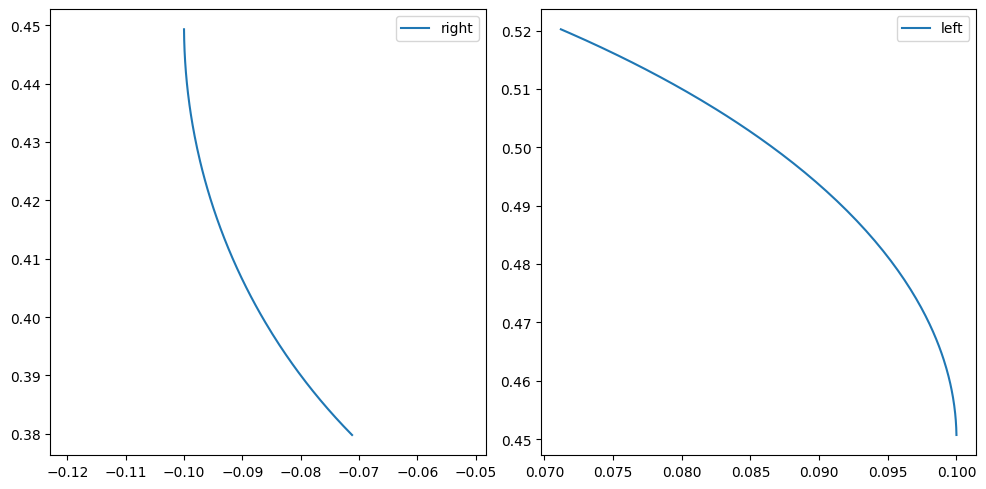

In [21]:
# 示教轨迹创建
# ----------------------------------------------------------------------------------------------------------------------
# 初始化变量
Y = np.zeros((n_steps, 14))
T = np.linspace(0, 1, len(Y))
sigmoid = 0.5 * (np.tanh(1.5 * np.pi * (T - 0.5)) + 1.0)  # 双曲正切函数 sigmoid=0.5*(tanh(pi*(t-0.5)+1.0)
radius = rotation_radius

# x y z -> -y x z
# left轨迹
circle1 = radius * np.cos(np.deg2rad(0) + np.deg2rad(45) * sigmoid)  # circle1=radius*cos(1/2*pi+1/2*pi*sigmoid)
circle2 = radius * np.sin(np.deg2rad(0) + np.deg2rad(45) * sigmoid)  # circle2=radius*sin(1/2*pi+1/2*pi*sigmoid)
Y[:, 0] = ee_left_start[0,3]
Y[:, 1] = circle1
Y[:, 2] = circle2 + ee_left_start[2,3]
R_gripper_vertical = pr.matrix_from_axis_angle(
    [0, 1, 0, np.deg2rad(-90)])  # R(y,-1/2*pi) {gripper_vertical}相对于(to->){center}的姿态(旋转矩阵)
R_to_center_start = pr.matrix_from_axis_angle(
    [1, 0, 0, np.deg2rad(90)])  # R(x,1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(45)])
q_start = pr.quaternion_from_matrix(R_gripper_vertical @ R_to_center_start)
q_end = pr.quaternion_from_matrix(R_rotation @ R_gripper_vertical @ R_to_center_start)
# 时间同步
for i, s in enumerate(sigmoid):
    Y[i, 3:7] = pr.quaternion_slerp(q_start, q_end, s)

# right轨迹
circle1 = radius * np.cos(np.deg2rad(180) + np.deg2rad(45) * sigmoid)
circle2 = radius * np.sin(np.deg2rad(180) + np.deg2rad(45) * sigmoid)
Y[:, 7] = ee_right_start[0,3]
Y[:, 8] = circle1
Y[:, 9] = circle2 + ee_left_start[2,3]
R_gripper_vertical = pr.matrix_from_axis_angle(
    [0, 1, 0, np.deg2rad(-90)])  # R(y,-1/2*pi) {gripper_vertical}相对于(to->){center}的姿态(旋转矩阵)
R_to_center_start = pr.matrix_from_axis_angle(
    [1, 0, 0, np.deg2rad(-90)])  # R(x,-1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(45)])
q_start = pr.quaternion_from_matrix(R_gripper_vertical @ R_to_center_start)
q_end = pr.quaternion_from_matrix(R_rotation @ R_gripper_vertical @ R_to_center_start)
# 时间同步
for i, s in enumerate(sigmoid):
    Y[i, 10:] = pr.quaternion_slerp(q_start, q_end, s)
# ----------------------------------------------------------------------------------------------------------------------
########################################################################################################################

# 绘图
fig = plt.figure(figsize=(10, 5)) # 创建图窗

# 设置子图属性
ax1 = fig.add_subplot(122)
ax1.plot(Y[:, 1], Y[:, 2], label="left")
# ax1.set_xlim((-0, 0.15))
# ax1.set_ylim((0.4, 0.6))

ax2 = fig.add_subplot(121)
ax2.plot(Y[:, 8], Y[:, 9], label="right")PyCF_DONT_IMPLY_DEDENT
# ax2.set_xlim((-0.15, 0.0))
# ax2.set_ylim((0.4, 0.6))

ax1.legend(loc="best")
ax2.legend(loc="best")

plt.axis('equal')
plt.tight_layout()
plt.show()


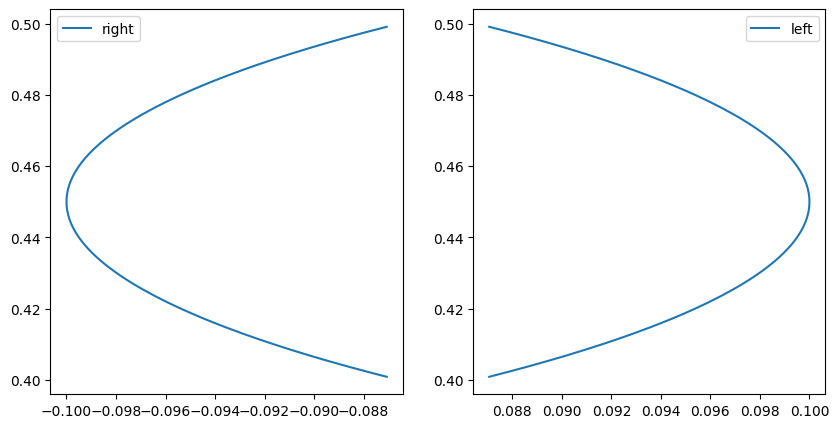

In [25]:
# 示教轨迹创建
# ----------------------------------------------------------------------------------------------------------------------
# 初始化变量
Y = np.zeros((n_steps, 14))
T = np.linspace(0, 1, len(Y))
sigmoid = 0.5 * (np.tanh(1.5 * np.pi * (T - 0.5)) + 1.0)  # 双曲正切函数 sigmoid=0.5*(tanh(pi*(t-0.5)+1.0)
radius = rotation_radius

# x y z -> -y x z
# left轨迹
# circle1 = radius * np.cos(np.deg2rad(0) + np.deg2rad(45) * sigmoid)  # circle1=radius*cos(1/2*pi+1/2*pi*sigmoid)
# circle2 = radius * np.sin(np.deg2rad(0) + np.deg2rad(45) * sigmoid)  # circle2=radius*sin(1/2*pi+1/2*pi*sigmoid)
# circle1 = radius * np.cos(np.deg2rad(0) + np.deg2rad(-30) * sigmoid)  # circle1=radius*cos(1/2*pi+1/2*pi*sigmoid)
# circle2 = radius * np.sin(np.deg2rad(0) + np.deg2rad(-30) * sigmoid)  # circle2=radius*sin(1/2*pi+1/2*pi*sigmoid)
circle1 = radius * np.cos(np.deg2rad(-30) + np.deg2rad(60) * sigmoid)  # circle1=radius*cos(1/2*pi+1/2*pi*sigmoid)
circle2 = radius * np.sin(np.deg2rad(-30) + np.deg2rad(60) * sigmoid)  # circle2=radius*sin(1/2*pi+1/2*pi*sigmoid)
Y[:, 0] = ee_left_start[0,3]
Y[:, 1] = circle1
Y[:, 2] = circle2 + ee_left_start[2,3]
R_gripper_vertical = pr.matrix_from_axis_angle(
    [0, 1, 0, np.deg2rad(-90)])  # R(y,-1/2*pi) {gripper_vertical}相对于(to->){center}的姿态(旋转矩阵)
# R_to_center_start = pr.matrix_from_axis_angle(
#     [1, 0, 0, np.deg2rad(90)])  # R(x,1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
R_to_center_start = pr.matrix_from_axis_angle(
    [1, 0, 0, np.deg2rad(90-30)])  # R(x,1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
# R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(45)])
# R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(30)])
# R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(-30)])
R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(60)])
q_start = pr.quaternion_from_matrix(R_gripper_vertical @ R_to_center_start)
q_end = pr.quaternion_from_matrix(R_rotation @ R_gripper_vertical @ R_to_center_start)
# 时间同步
for i, s in enumerate(sigmoid):
    Y[i, 3:7] = pr.quaternion_slerp(q_start, q_end, s)

# right轨迹
# circle1 = radius * np.cos(np.deg2rad(180) + np.deg2rad(45) * sigmoid)
# circle2 = radius * np.sin(np.deg2rad(180) + np.deg2rad(45) * sigmoid)
# circle1 = radius * np.cos(np.deg2rad(180) + np.deg2rad(-30) * sigmoid)
# circle2 = radius * np.sin(np.deg2rad(180) + np.deg2rad(-30) * sigmoid)
circle1 = radius * np.cos(np.deg2rad(180-30) + np.deg2rad(60) * sigmoid)
circle2 = radius * np.sin(np.deg2rad(180-30) + np.deg2rad(60) * sigmoid)
Y[:, 7] = ee_right_start[0,3]
Y[:, 8] = circle1
Y[:, 9] = circle2 + ee_left_start[2,3]
R_gripper_vertical = pr.matrix_from_axis_angle(
    [0, 1, 0, np.deg2rad(-90)])  # R(y,-1/2*pi) {gripper_vertical}相对于(to->){center}的姿态(旋转矩阵)
R_to_center_start = pr.matrix_from_axis_angle(
    [1, 0, 0, np.deg2rad(-90+30)])  # R(x,-1/2*pi) {center}相对于{base}的初始姿态(旋转矩阵)
# R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(45)])
# R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(30)])
# R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(-30)])
R_rotation = pr.matrix_from_axis_angle([1, 0, 0, np.deg2rad(60)])
q_start = pr.quaternion_from_matrix(R_gripper_vertical @ R_to_center_start)
q_end = pr.quaternion_from_matrix(R_rotation @ R_gripper_vertical @ R_to_center_start)
# 时间同步
for i, s in enumerate(sigmoid):
    Y[i, 10:] = pr.quaternion_slerp(q_start, q_end, s)
# ----------------------------------------------------------------------------------------------------------------------
########################################################################################################################

# 绘图
fig = plt.figure(figsize=(10, 5)) # 创建图窗

# 设置子图属性
ax1 = fig.add_subplot(122)
# ax1.set_title("Dimension 1")
# ax1.set_ylim((-3, 3))
ax2 = fig.add_subplot(121)
# ax2.set_title("Dimension 2")
# ax2.set_ylim((-3, 3))
ax1.plot(Y[:, 1], Y[:, 2], label="left")
ax2.plot(Y[:, 8], Y[:, 9], label="right")

ax1.legend(loc="best")
ax2.legend(loc="best")

plt.show()